## Data Augmentation

- artificiellt skapa fler bilder
- slumpmässigt:
 - roterar till en viss grad (radianer)
 - translatera slumpmässigt
 - flippa horisontellt
 - shear

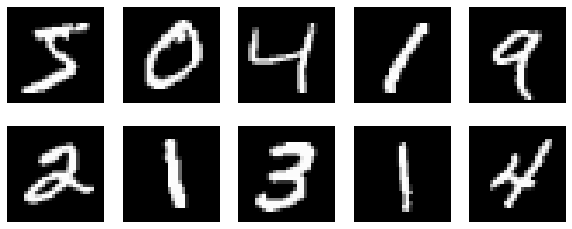

In [52]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()


def plot_samples(data):
    fig, axes = plt.subplots(2,5, figsize = (10,4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")

plot_samples(X_train)

In [53]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train / Test / Split

In [54]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1/6, random_state=42)

X_train_val = X_train_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]
X_test = X_test[:,:,:,None]
X_train_val.shape

(50000, 28, 28, 1)

## Data augmentation

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range = 10, 
    shear_range = .2,
    zoom_range = .1,
    horizontal_flip = False,
    height_shift_range = .2,
    width_shift_range = .2,
)

#don't augment validation and test data
test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(
    X_train_val, y_train_val, batch_size = 32)

val_generator = test_image_generator.flow(
    X_val, y_val, batch_size = 32)

train_val_generator, val_generator


(<keras.preprocessing.image.NumpyArrayIterator at 0x1f3cf281e50>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x1f3cf281fa0>)

2
(32, 28, 28, 1)


array([2, 8, 9, 8, 9, 6, 5, 2, 1, 3, 7, 3, 6, 8, 4, 1, 1, 9, 5, 9, 4, 3,
       3, 0, 4, 2, 1, 1, 8, 8, 2, 3], dtype=uint8)

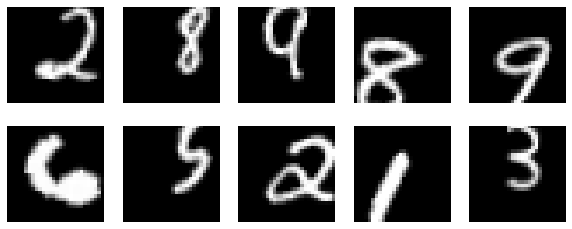

In [56]:
print(len(train_val_generator.next()))

sample_batch = train_val_generator.next()
print(sample_batch[0].shape) # 32 samples in a batch

plot_samples(sample_batch[0])
sample_batch[1]

## CNN Model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32,32]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name = "CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), 
            activation = "relu", kernel_initializer = "he_normal", 
            input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    #MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate=.5)
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0 